In [4]:
import pandas as pd

# 데이터를 읽어오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 리스트

def load_data(train_data, test_data, num_words=10000):
    # 텍스트 데이터 전처리
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어 빈도수 계산
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    
    # 단어 사전 생성
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 단어 리스트를 인덱스 리스트로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    # 학습 데이터와 테스트 데이터를 인덱스 시퀀스로 변환
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(X_train[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]


In [6]:
# 문장을 단어 인덱스 리스트로 변환하며 시작에 <BOS> 토큰을 추가
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 문장 리스트를 인덱스 시퀀스 리스트로 변환
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 인덱스 시퀀스를 단어 문자열로 복원 (맨 앞 <BOS> 제외)
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

# 인덱스 시퀀스 리스트를 문장 리스트로 복원
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}
#print(index_to_word)
print(list(index_to_word.items())[:200])

[(0, '<PAD>'), (1, '<BOS>'), (2, '<UNK>'), (3, '<UNUSED>'), (4, '.'), (5, '영화'), (6, '다'), (7, '고'), (8, '하'), (9, '을'), (10, '보'), (11, '..'), (12, '게'), (13, ','), (14, '!'), (15, '지'), (16, '있'), (17, '없'), (18, '?'), (19, '좋'), (20, '나'), (21, '었'), (22, '만'), (23, '는데'), (24, '너무'), (25, '봤'), (26, '적'), (27, '안'), (28, '정말'), (29, '로'), (30, '음'), (31, '것'), (32, '아'), (33, '네요'), (34, '재밌'), (35, '어'), (36, '같'), (37, '점'), (38, '지만'), (39, '진짜'), (40, '했'), (41, '에서'), (42, '기'), (43, '네'), (44, '않'), (45, '거'), (46, '았'), (47, '수'), (48, '되'), (49, '면'), (50, 'ㅋㅋ'), (51, '말'), (52, '연기'), (53, '인'), (54, '주'), (55, '내'), (56, '최고'), (57, '~'), (58, '평점'), (59, '이런'), (60, '던'), (61, '어요'), (62, '할'), (63, '왜'), (64, '겠'), (65, '1'), (66, '스토리'), (67, '해'), (68, '습니다'), (69, 'ㅋㅋㅋ'), (70, '...'), (71, '드라마'), (72, '생각'), (73, '아니'), (74, '더'), (75, '그'), (76, '싶'), (77, '사람'), (78, '듯'), (79, '때'), (80, '감동'), (81, '함'), (82, '배우'), (83, '본'), (84, '까지'), (85, '뭐'), (86, '알'), (

In [110]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리


In [111]:
# 맨 앞 글자가 잘리는 문제가 있어서 확인하고자 만들어봄
# 데이터셋에는 문장 앞에 <BOS>가 추가 되어있지 않은데
# get_decoded_sentence에서는 이를 고려해주어 문장을 인덱스 1부터 보기 때문에 발생하는 문제였음
# 중요하게 쓰이는 함수는 아니기 때문에 아래와 같은 간단한 테스트만 해보고 넘어감
def get_decoded_sentence_no_skip(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence)

print(get_decoded_sentence_no_skip(X_train[0], index_to_word))

아 더 빙 . . 진짜 짜증 나 네요 목소리


In [112]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [113]:
# 문장 앞에 패딩
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 'pre' or 'post'
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 'pre' or 'post'
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

(146182, 41)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  32  74 919   4   4
  39 228  20  33 748]
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리


In [114]:
import tensorflow as tf
import os

vocab_size = len(word_to_index)    # 어휘 사전의 크기
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [115]:
# validation set 10000건 분리
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [116]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
208/208 [==============================] - 3s 8ms/step - loss: 0.5249 - accuracy: 0.7640 - val_loss: 0.3760 - val_accuracy: 0.8397
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3456 - accuracy: 0.8541 - val_loss: 0.3487 - val_accuracy: 0.8491
Epoch 3/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3175 - accuracy: 0.8683 - val_loss: 0.3466 - val_accuracy: 0.8497
Epoch 4/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3042 - accuracy: 0.8747 - val_loss: 0.3476 - val_accuracy: 0.8497
Epoch 5/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2935 - accuracy: 0.8794 - val_loss: 0.3510 - val_accuracy: 0.8485
Epoch 6/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2845 - accuracy: 0.8838 - val_loss: 0.3519 - val_accuracy: 0.8490
Epoch 7/20
208/208 [==============================] - 1s 6ms/step - loss: 0.2751 - accuracy: 0.8875 - val_loss: 0.3587 - val_accuracy: 0.8477
Epoch 

In [117]:
# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.5383 - accuracy: 0.8369
[0.5383302569389343, 0.8368695974349976]


In [118]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


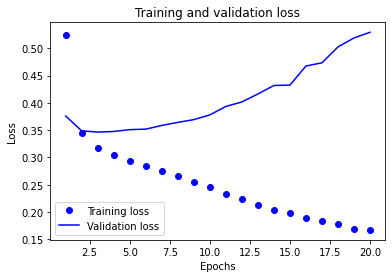

In [119]:
import matplotlib.pyplot as plt

# 그래프 시각화
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

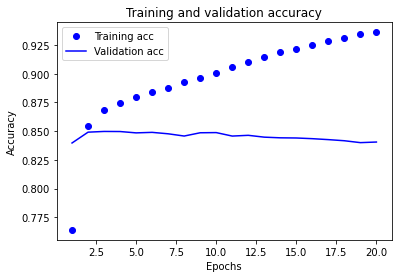

In [120]:
plt.clf()   # 그림 초기화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

> 노드 학습 코드를 그대로 사용하면 Overfitting이 빠르게 이루어짐.
> - 이를 해결하기 위해 특수문자를 전부 제거해봄.

## 특수문자 제거 실험

In [14]:
import re

def my_load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    def clean_text(text):
        return re.sub(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]', '', text)  # 한글, 공백, 숫자, 영어만 남기고 모두 제거
    
    train_data['document'] = train_data['document'].apply(clean_text)
    test_data['document'] = test_data['document'].apply(clean_text)
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = my_load_data(train_data, test_data) 
print(X_train[0])

/tmp/ipykernel_64/3437164130.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].apply(clean_text)
/tmp/ipykernel_64/3437164130.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'] = test_data['document'].apply(clean_text)


[28, 67, 913, 34, 216, 15, 27, 712]


In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}
#print(index_to_word)
print(list(index_to_word.items())[:200])

[(0, '<PAD>'), (1, '<BOS>'), (2, '<UNK>'), (3, '<UNUSED>'), (4, '영화'), (5, '다'), (6, '고'), (7, '하'), (8, '을'), (9, '보'), (10, '게'), (11, '지'), (12, '있'), (13, '없'), (14, '좋'), (15, '나'), (16, '었'), (17, '만'), (18, '는데'), (19, '너무'), (20, '봤'), (21, '적'), (22, '안'), (23, '정말'), (24, '로'), (25, '음'), (26, '것'), (27, '네요'), (28, '아'), (29, '재밌'), (30, '어'), (31, '지만'), (32, '같'), (33, '점'), (34, '진짜'), (35, '에서'), (36, '했'), (37, '기'), (38, '네'), (39, '않'), (40, '거'), (41, '았'), (42, '수'), (43, '되'), (44, '면'), (45, 'ㅋㅋ'), (46, '인'), (47, '말'), (48, '연기'), (49, '주'), (50, '최고'), (51, '내'), (52, '평점'), (53, '이런'), (54, '던'), (55, '어요'), (56, '할'), (57, '왜'), (58, '겠'), (59, '스토리'), (60, '해'), (61, 'ㅋㅋㅋ'), (62, '습니다'), (63, '듯'), (64, '아니'), (65, '드라마'), (66, '생각'), (67, '더'), (68, '그'), (69, '1'), (70, '싶'), (71, '사람'), (72, '때'), (73, '감동'), (74, '배우'), (75, '함'), (76, '본'), (77, '까지'), (78, '뭐'), (79, '알'), (80, '만들'), (81, '내용'), (82, '볼'), (83, '보다'), (84, '감독'), (85, '라'), (86, '그냥'),

In [137]:
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))

[28, 67, 913, 34, 216, 15, 27, 712]
더 빙 진짜 짜증 나 네요 목소리


In [142]:
def model_test(model, X_train, X_test, ep):
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                            value=word_to_index["<PAD>"],
                                                            padding='pre', # 'pre', 'post'
                                                            maxlen=maxlen)
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                           value=word_to_index["<PAD>"],
                                                           padding='pre', # 'pre', 'post'
                                                           maxlen=maxlen)

    vocab_size = len(word_to_index)    # 어휘 사전의 크기
    word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

    x_val = X_train[:40000]   
    y_val = y_train[:40000]
    partial_x_train = X_train[40000:]  
    partial_y_train = y_train[40000:]


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=ep,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)

    results = model.evaluate(X_test, y_test, verbose=2)
    print(results)

    # 시각화
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # 그림을 초기화합니다
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
208/208 [==============================] - 3s 8ms/step - loss: 0.5439 - accuracy: 0.7460 - val_loss: 0.4099 - val_accuracy: 0.8184
Epoch 2/20
208/208 [==============================] - 1s 6ms/step - loss: 0.3592 - accuracy: 0.8496 - va

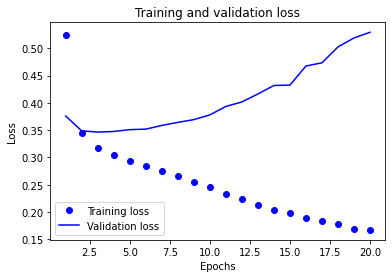

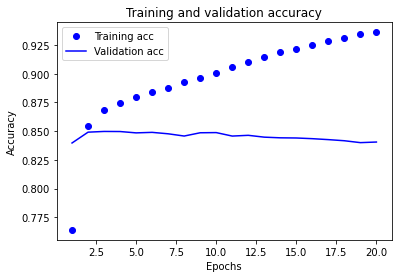

In [138]:
# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 20)

accuracy가 0.8369에서 0.8305로 감소하였다.
이를 통해 특수문자 제거가 무조건 정확도를 상승시키진 않는다는 것을 알 수 있었다.
감정 표현에서는 특수문자가 강조, 감정, 뉘앙스를 나타내는 중요한 신호가 될 수 있다.

## 여러 모델 테스트

#### 1. LSTM 모델의 unit 개수를 128개로 늘리고 Recurrent Dropout을 추가함. epochs는 10으로 줄임.

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 235,281
Trainable params: 235,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
208/208 [==============================] - 40s 182ms/step - loss: 0.4857 - accuracy: 0.7554 - val_loss: 0.3636 - val_accuracy: 0.8411
Epoch 2/10
208/208 [==============================] - 38s 

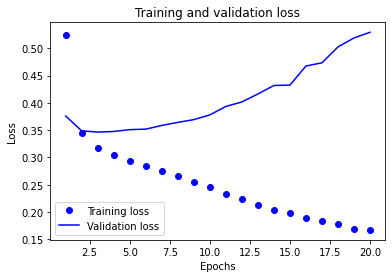

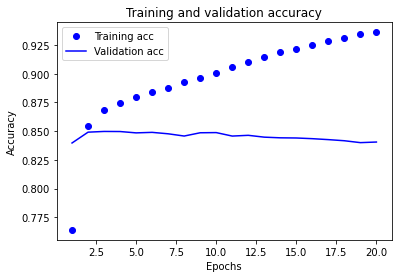

In [149]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(X_train[0])

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 10)

- accuracy가 0.8487로 상승

#### 2. GRU 모델의 unit 개수를 128개로 하고 Recurrent Dropout을 추가함.

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               56064     
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 217,105
Trainable params: 217,105
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
208/208 [==============================] - 36s 165ms/step - loss: 0.4656 - accuracy: 0.7761 - val_loss: 0.3702 - val_accuracy: 0.8363
Epoch 2/10
208/208 [==============================] - 34s 

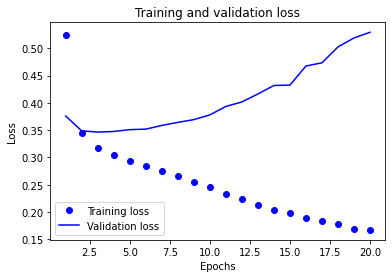

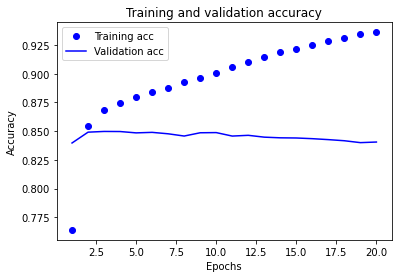

In [144]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(X_train[0])

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GRU(128, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 10)

- accuracy가 0.8495로 1번 모델보다 좋음

#### 3. CNN의 conv1d사용

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         10368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 187,009
Trainable params: 187,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
208/208 [==============================] - 2s 8ms/step - los

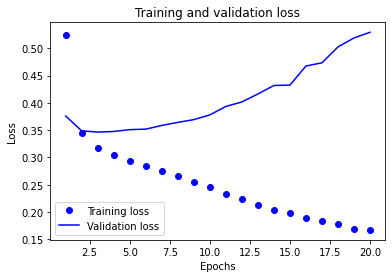

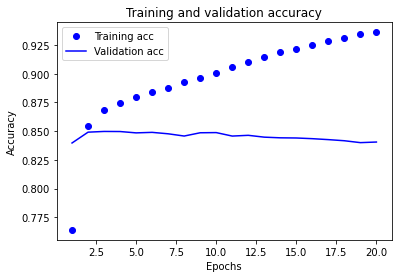

In [148]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(X_train[0])

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 10)

- accuracy는 0.8310이고 속도가 가장 빨랐음

#### 4. 기본 모델에서 unit 개수만 8에서 32로 늘려봄.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 166,545
Trainable params: 166,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
208/208 [==============================] - 3s 8ms/step - loss: 0.4821 - accuracy: 0.7670 - val_loss: 0.3657 - val_accuracy: 0.8389
Epoch 2/10
208/208 [==============================] - 1s 6ms/step - loss: 0.3387 - accuracy: 0.8559 - v

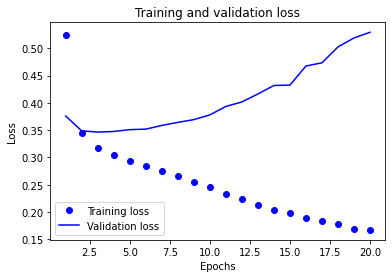

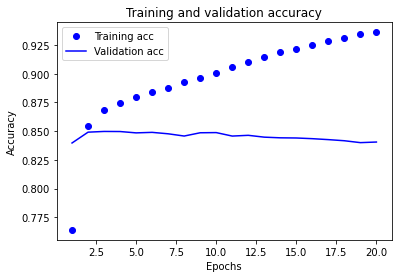

In [146]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 10)

- unit 개수가 증가할수록 accuracy가 좋아지는 모습을 볼 수 있었다.

#### 5. 1번 모델에서 recurrent dropout을 적용하지 않은 모델

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 235,281
Trainable params: 235,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
208/208 [==============================] - 4s 12ms/step - loss: 0.5103 - accuracy: 0.7418 - val_loss: 0.3674 - val_accuracy: 0.8386
Epoch 2/10
208/208 [==============================] - 2s 10ms/step - loss: 0.3414 - accuracy: 0.8544 -

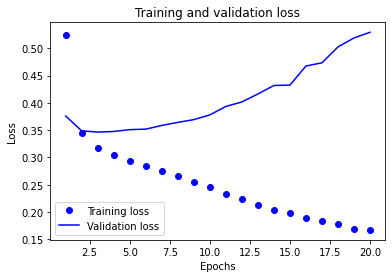

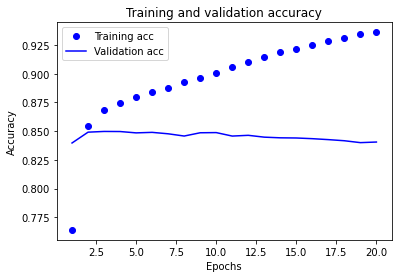

In [147]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

model_test(model, X_train, X_test, 10)

- recurrent dropout을 적용한 모델이 accuracy가 더 좋음

## Word2Vec

### 학습된 Embedding 레이어 분석

In [150]:
embedding_layer = model.layers[0]   # 1번 모델 사용(원래는 1번 모델이 가장 좋았는데 학습된 임베딩 분석을 위해 다시 학습시키니 GRU보다 성능이 떨어짐)
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [151]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(1,vocab_size-3):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [152]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.01160172,  0.00294956,  0.00558525, -0.0037075 , -0.01193209,
        0.00576786,  0.00779008, -0.02378491, -0.00094846,  0.004616  ,
        0.00242004, -0.01108154,  0.00851314, -0.02505308,  0.02695868,
        0.00099263], dtype=float32)

In [153]:
word_vectors.similar_by_word("재미")

[('기다린', 0.8962247371673584),
 ('니까요', 0.8789691925048828),
 ('다섯', 0.8788926005363464),
 ('싸인', 0.8756279349327087),
 ('댕기', 0.8679208755493164),
 ('였', 0.8639389872550964),
 ('건', 0.8553878664970398),
 ('으셨', 0.8434863686561584),
 ('한숨', 0.8242340683937073),
 ('비주얼', 0.8214759230613708)]

### 사전 학습된 Embedding 레이어 분석

In [164]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)

vector = word2vec.wv['영화']
print(vector)

[-1.8007389  -1.1790098  -2.4066596   2.1384156  -0.3537603   1.3749527
 -4.894612   -3.6517198   0.4411444   0.78153926 -2.696888   -1.7812852
 -2.1514654  -4.813236    2.7465918  -2.1620324  -0.11467794 -1.2431171
  2.3979309  -1.1060628  -0.41043055  1.9500391   0.7821002   1.5899978
  1.6447444  -2.1265035  -1.7981595   1.7535795   0.53717697 -1.212121
 -4.466316    4.5488324   1.334441   -0.9070271   1.1931889   4.1563215
  1.9758307  -0.9437562  -0.2592725   0.34935686  1.8562875  -3.3249645
  1.1221625   1.2836524   3.9211376   3.8023994   2.766269    0.67293745
  2.2853644  -5.1131716   0.32525915 -3.3079958   5.3043513  -3.8813758
 -0.32960036 -1.9527504   3.8865075  -3.5470378  -0.21991685  0.82119733
 -0.9492492   3.5472107   1.322048   -0.70640826  0.52253807  1.4683235
 -1.1018689   2.262941   -0.7204685  -1.766201    5.2237577   3.0748682
  1.0977576   3.3191733  -0.4100423  -1.7022891  -0.78379875  0.82586575
 -0.54520637  1.2355382   2.02674    -0.652447    1.0866054   

In [165]:
word2vec.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [172]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
Epoch 1/10
208/208 [==============================] - 42s 192ms/step - loss: 0.5825 - accuracy: 0.6822 - val_loss: 0.4887 - val_accuracy: 0.7681
Epoch 2/10
208/208 [==============================] - 

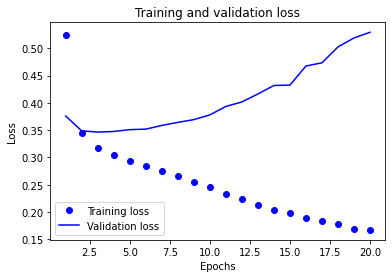

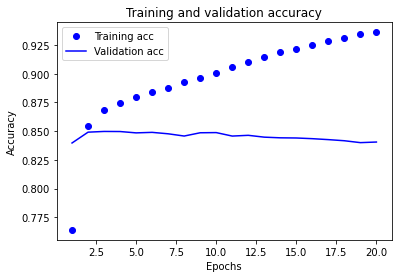

In [177]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(X_train[0])

model_test(model, X_train, X_test, 10)

> accuracy : 0.8512
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성

#### 회고
- 텍스트 데이터 전처리 과정에서 특수문자를 제거하는 것이 항상 좋은 것이 아니라 특수문자도 분석에 중요한 요인이 될 수 있다는 것을 알게 되었다.
- 한 단어와 그와 가장 유사한 단어와의 유사도를 확인해보는 과정을 통해 단어를 임베딩한 임베딩 벡터의 역할을 잘 알 수 있었다.